In [1]:
import geopandas as gpd
from h3 import h3
import folium
import shapely.geometry

boros = gpd.read_file('../data/shapefiles/nyc/boro_bounds.geojson')

ModuleNotFoundError: No module named 'h3'

In [ ]:
## From Will Geary: https://github.com/willgeary/covid-nyc-dasymetric-map/blob/master/notebook.ipynb

# Creating an H3 Hexagon Grid
def create_hexgrid(polygon, hex_res, geometry_col='geometry', map_zoom=12, buffer=0.000,
                   stroke_weight=0.5, stroke_color='blue', plot=True):
    """ Takes in a geopandas geodataframe, the desired resolution, the specified geometry column
        and some map parameters to create a hexagon grid (and potentially plot the hexgrid
    """
    centroid = list(polygon.centroid.values[0].coords)[0]
    fol_map = folium.Map(location=[centroid[1], centroid[0]], zoom_start=map_zoom,
                         tiles='cartodbpositron')

    # Explode multipolygon into individual polygons
    exploded = polygon.explode().reset_index(drop=True)

    # Master lists for geodataframe
    hexagon_polygon_list = []
    hexagon_geohash_list = []

    # For each exploded polygon
    for poly in exploded[geometry_col].values:

        # Reverse coords for original polygon
        coords = list(poly.exterior.coords)
        reversed_coords = []
        for i in coords:
            reversed_coords.append([i[1], i[0]])

        # Reverse coords for buffered polygon
        buffer_poly = poly.buffer(buffer)
        buffer_coords = list(buffer_poly.exterior.coords)
        reversed_buffer_coords = []
        for i in buffer_coords:
            reversed_buffer_coords.append([i[1], i[0]])

        # Format input to the way H3 expects it
        aoi_input = {'type': 'Polygon', 'coordinates': [reversed_buffer_coords]}

        # Add polygon outline to map
        outline = reversed_coords
        outline.append(outline[0])
        outline = folium.PolyLine(locations=outline, weight=1, color='black')
        fol_map.add_child(outline)

        # Generate list geohashes filling the AOI
        geohashes = list(h3.polyfill(aoi_input, hex_res))

        # Generate hexagon polylines for Folium
        polylines = []
        lat = []
        lng = []
        for geohash in geohashes:
            polygons = h3.h3_set_to_multi_polygon([geohash], geo_json=False)
            outlines = [loop for polygon in polygons for loop in polygon]
            polyline = [outline + [outline[0]] for outline in outlines][0]
            lat.extend(map(lambda x: x[0], polyline))
            lng.extend(map(lambda x: x[1], polyline))
            polylines.append(polyline)
            hexagon_geohash_list.append(geohash)

        # Add the hexagon polylines to Folium map
        for polyline in polylines:
            my_polyline = folium.PolyLine(locations=polyline, weight=stroke_weight,
                                          color=stroke_color)
            fol_map.add_child(my_polyline)

        # Generate hexagon polygons for Shapely
        for geohash in geohashes:
            polygons = h3.h3_set_to_multi_polygon([geohash], geo_json=True)
            outlines = [loop for polygon in polygons for loop in polygon]
            polyline_geojson = [outline + [outline[0]] for outline in outlines][0]
            hexagon_polygon_list.append(shapely.geometry.Polygon(polyline_geojson))

    if plot:
        display(fol_map)

    # Create a geodataframe containing the hexagon geometries and hashes
    hexgrid_gdf = gpd.GeoDataFrame()
    hexgrid_gdf['geometry'] = hexagon_polygon_list
    id_col_name = 'hex_id_' + str(hex_res)
    hexgrid_gdf[id_col_name] = hexagon_geohash_list
    hexgrid_gdf.crs = {'init' :'epsg:4326'}

    # Drop duplicate geometries
    geoms_wkb = hexgrid_gdf["geometry"].apply(lambda geom: geom.wkb)
    hexgrid_gdf = hexgrid_gdf.loc[geoms_wkb.drop_duplicates().index]

    return hexgrid_gdf

/Users/nicholaslicalzi/anaconda3/envs/geo_env/lib/python3.8/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


(1199, 2)


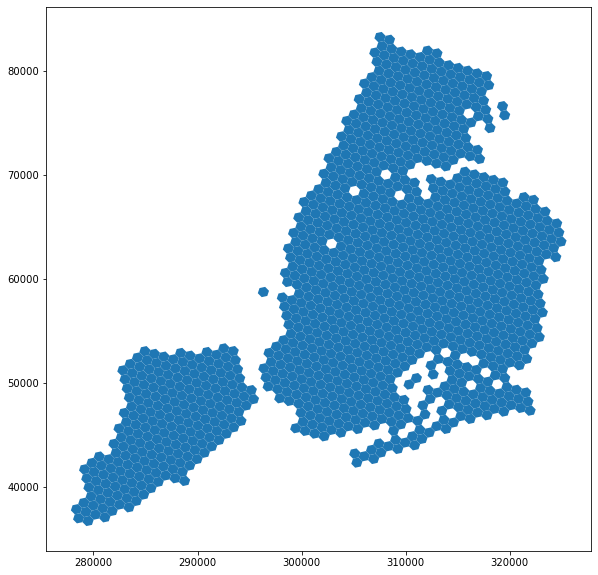

In [6]:
hexagons = create_hexgrid(boros, hex_res = 8, buffer=0.002, plot=False)
hexagons = hexagons.to_crs(epsg=3627) # project to state plane

print(hexagons.shape)
hexagons.plot(figsize=(10,10));

In [7]:
hexagons.to_file("../data/shapefiles/nyc/hexagons.geojson", driver='GeoJSON')